In [11]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd   

from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV

from sklearn import svm
from sklearn.neural_network import MLPClassifier

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

Preprocessing

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   
5            7.4              0.66         0.00             1.8      0.075   
6            7.9              0.60         0.06             1.6      0.069   
7            7.3              0.65         0.00             1.2      0.065   
8            7.8              0.58         0.02             2.0      0.073   
9            7.5              0.50         0.36             6.1      0.071   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0

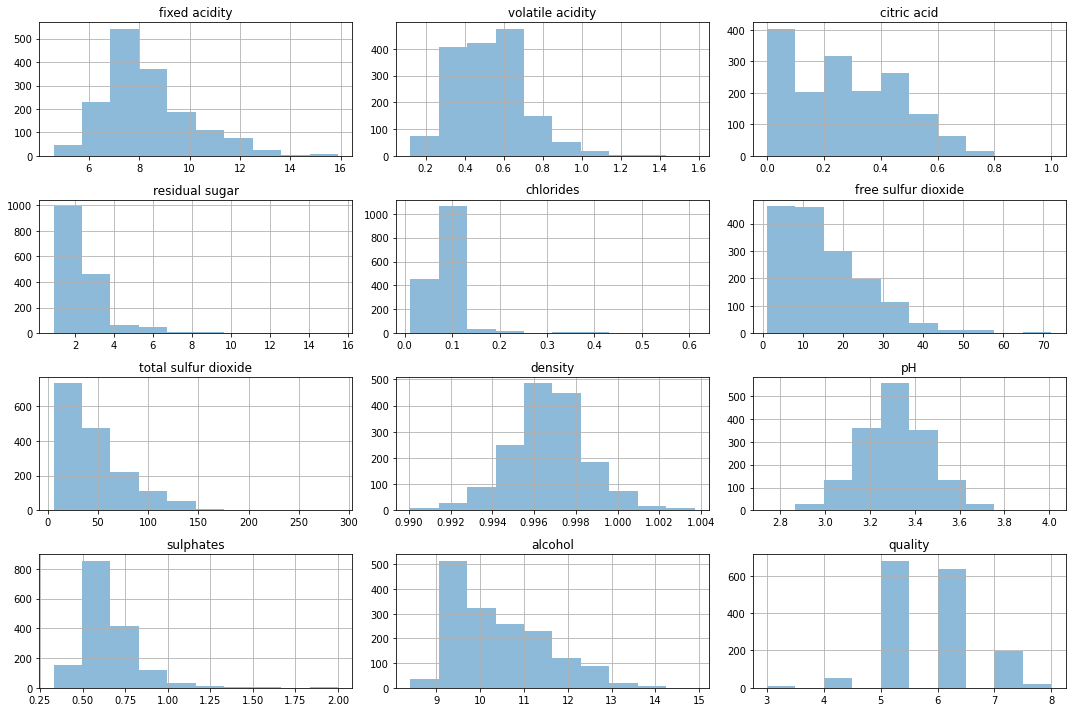


Checking for null values: 


Checking for null values after using fillna(): 



fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [3]:
headerList = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']

wineData = pd.read_csv('winequality-red.csv', header = 0, names = headerList, sep=";")
print(wineData.head(10))

#Summarative functions
wineData.dtypes
wineData.describe()
wineData.info()

#Plotting histogram of each variable
wineData.hist(alpha=0.5, figsize=(15, 10))
plt.tight_layout()
plt.show()

for h in headerList:
  wineData[h] = pd.to_numeric(wineData[h], errors='coerce')

print("\nChecking for null values: \n")
wineData.isna().sum()

#We see there are 4 + 2 = 6 NaN cells 
wineData = wineData.fillna(0)

#Check for null instances
print("\nChecking for null values after using fillna(): \n")
wineData.isna().sum()


PCA

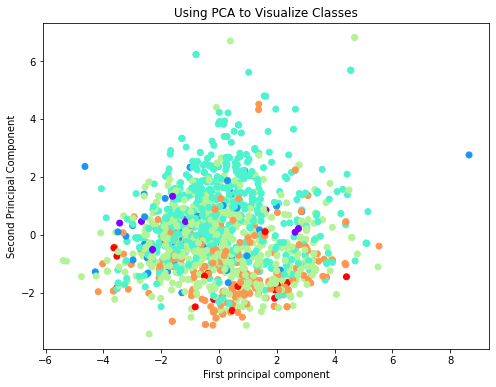

In [4]:
#PCA
df_pca = wineData.copy()
X_pca = df_pca.loc[:, 'fixed acidity':'alcohol']
y_pca = df_pca['quality']

X_pca.tail()

#Preprocessing in preparation for PCA: Standardizing the predictor variables
X_pca = StandardScaler().fit_transform(X_pca)

#Fit PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_pca)

X_pca.shape

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0],X_pca[:,1],c=y_pca,cmap='rainbow')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')
plt.title("Using PCA to Visualize Classes")
plt.show()

In [5]:
print("components: ", pca.components_, "\n")
print("explained variance: ", pca.explained_variance_, "\n")
exp_var_rat = pca.explained_variance_ratio_
print("explained variance ratio: ", exp_var_rat)

components:  [[ 0.48931422 -0.23858436  0.46363166  0.14610715  0.21224658 -0.03615752
   0.02357485  0.39535301 -0.43851962  0.24292133 -0.11323206]
 [-0.11050274  0.27493048 -0.15179136  0.27208024  0.14805156  0.51356681
   0.56948696  0.23357549  0.00671079 -0.03755392 -0.38618096]] 

explained variance:  [3.10107182 1.92711489] 

explained variance ratio:  [0.28173931 0.1750827 ]


<AxesSubplot:>

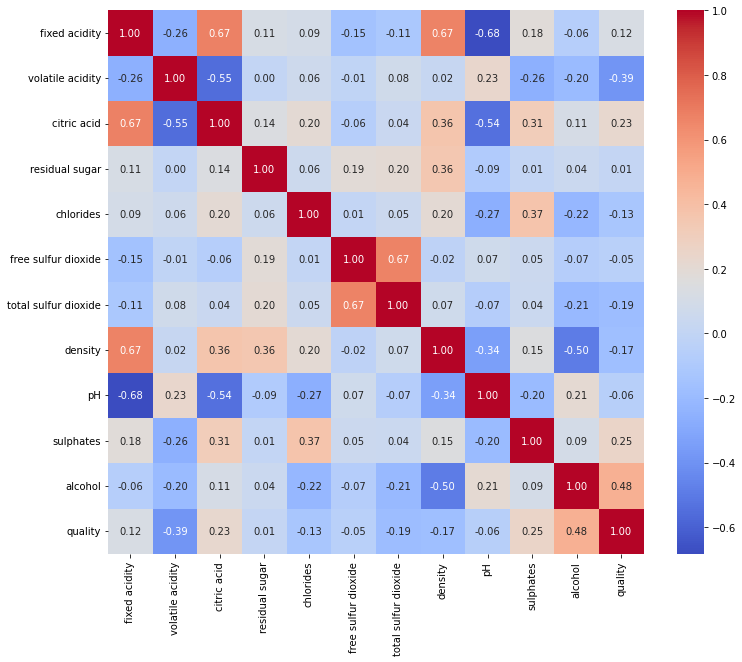

In [8]:
import seaborn as sns

plt.figure(figsize=(12,10))
sns.heatmap(wineData.corr(),annot=True, cmap='coolwarm',fmt='.2f')

In [10]:
#Split data into training and test sets
X = wineData.loc[:, 'fixed acidity':'alcohol']
y = wineData['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=10) #split the data
X_train.shape, y_train.shape, X_test.shape, y_test.shape

#Use sklearn.preprocessing.StandardScaler to standardize predictors 
scaledData = StandardScaler()
X_train = scaledData.fit_transform(X_train)
X_test = scaledData.transform(X_test)

In [13]:
bestFeatures = SelectKBest(score_func=chi2, k=11)
bestFeaturesFit = bestFeatures.fit(X,y)
dfscores = pd.DataFrame(bestFeaturesFit.scores_)
dfcolumns = pd.DataFrame(X.columns) 
predScores = pd.concat([dfcolumns,dfscores],axis=1)
predScores.columns = ['Predictor','Score']
print(predScores.nlargest(11,'Score'))   

               Predictor        Score
6   total sulfur dioxide  2755.557984
5    free sulfur dioxide   161.936036
10               alcohol    46.429892
1       volatile acidity    15.580289
2            citric acid    13.025665
0          fixed acidity    11.260652
9              sulphates     4.558488
3         residual sugar     4.123295
4              chlorides     0.752426
8                     pH     0.154655
7                density     0.000230


In [14]:
#Drop the bottom two features (smallest score)
selectedDf = wineData.drop('density', 1)
selectedDf = selectedDf.drop('pH', 1)

selX = selectedDf.loc[:, 'fixed acidity':'alcohol']
selY = selectedDf['quality']

selX_train, selX_test, selY_train, selY_test = train_test_split(selX, selY, test_size = .2, random_state=10) #split the data
selX_train.shape, selY_train.shape, selX_test.shape, selY_test.shape

selX_train = scaledData.fit_transform(selX_train)
selX_test = scaledData.transform(selX_test)

/var/folders/7w/dj46r5ks7tsglt695mmbyhjr0000gn/T/ipykernel_26509/675771298.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  selectedDf = wineData.drop('density', 1)
/var/folders/7w/dj46r5ks7tsglt695mmbyhjr0000gn/T/ipykernel_26509/675771298.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  selectedDf = selectedDf.drop('pH', 1)


Support Vector Machine Model

Artificial Neural Networks

In [ ]:
train_score = []
test_score = []
for i in input:
   MLP = MLPClassifier(activation = 'logistic', 
                       solver = 'sgd', 
                       hidden_layer_sizes = (100,), 
                       alpha=1e-2, 
                       max_iter = 400,
                       learning_rate_init = 0.1)
   MLP.fit(x_train,y_train)
   print('train score: ', 'layers = ',i,'score = ',MLP.score(x_train,y_train))
   print('test score: ', 'layers = ',i,'score = ',MLP.score(x_test,y_test))
   train_score.append(MLP.score(x_train,y_train))
   test_score.append(MLP.score(x_test,y_test))

# Plot scores
plt.plot(layers,train_score,'.',label = 'train set')
plt.plot(layers,test_score,'-',label = 'test set')
plt.xlabel('layers')
plt.ylabel('score')
plt.legend()
plt.xscale("log")